In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy
import re

# Adding library directory to python search path
import os
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

## Первичные экпериментальные данные

### Шум

In [2]:
noise = mipt.read_excel('data/5.4.3.xlsx', usecols=('A', 'B', 'C', 'D', 'E', 'F', 'G', 'H'), header=(0, 1)).dropna()

fmt = {
    ('Noise', 't1') : [r'$t_1$, мин', '{:.0f}', 0],
    ('Noise', 't2') : [r'$t_2$, мин', '{:.0f}', 0],
    ('Noise', 'n1') : [r'$n_1$', '{:.1f}', 0],
    ('Noise', 'n2') : [r'$n_2$', '{:.1f}', 0],
    ('Noise', 'dn1') : [r'$\sigma_{n_1}$', '{:.0f}', 0],
    ('Noise', 'dn2') : [r'$\sigma_{n_2}$', '{:.0f}', 0],
    ('Noise', 'N1') : [r'$N_1$', '{:.0f}', 0],
    ('Noise', 'N2') : [r'$N_2$', '{:.0f}', 0],
    ('Noise') : [r'$Шум$', '{:.0f}', 0],
}

tab = mipt.table(noise, fmt)
tab.to_latex('gen/tab-noise.tex')

noise = noise['Noise']

### Отдельный

In [3]:
separate = mipt.read_excel('data/5.4.3.xlsx', usecols=('J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q'), header=(0, 1)).dropna()

fmt = {
    ('Separate', 't1') : [r'$t_1$, мин', '{:.0f}', 0],
    ('Separate', 't2') : [r'$t_2$, мин', '{:.0f}', 0],
    ('Separate', 'n1') : [r'$n_1$', '{:.0f}', 0],
    ('Separate', 'n2') : [r'$n_2$', '{:.0f}', 0],
    ('Separate', 'dn1') : [r'$\sigma_{n_1}$', '{:.0f}', 0],
    ('Separate', 'dn2') : [r'$\sigma_{n_2}$', '{:.0f}', 0],
    ('Separate', 'N1') : [r'$N_1$', '{:.0f}', 0],
    ('Separate', 'N2') : [r'$N_2$', '{:.0f}', 0],
    ('Separate') : [r'ФЭУ', '{:.0f}', 0],
}

tab = mipt.table(separate, fmt)
tab.to_latex('gen/tab-separate.tex')

separate = separate['Separate']

### Режим совпадений

In [4]:
overlap = mipt.read_excel('data/5.4.3.xlsx', usecols=('S', 'T', 'U', 'V', 'W'), header=(0, 1)).dropna()

fmt = {
    ('Overlap', 'tau, us') : [r'$\tau$, мкс', '{:.1f}', 0],
    ('Overlap', 't') : [r'$t$, мин', '{:.0f}', 0],
    ('Overlap', 'n') : [r'$n$', '{:.1f}', 0],
    ('Overlap', 'dn') : [r'$\sigma_{n}$', '{:.1f}', 0],
    ('Overlap', 'N') : [r'$N$', '{:.0f}', 0],
    ('Overlap') : [r'СС в режиме совпадений', '{:.0f}', 0],
}

tab = mipt.table(overlap, fmt)
tab.to_latex('gen/tab-overlap.tex')

overlap = overlap['Overlap']

## Обработка

### Шум отдельного ФЭУ

In [5]:
# Результаты повторяются каждый раз.
# Погрешность совпадает с погрешностью одного измерения / корень n.
n1_noise = noise['n1'].mean()
dn1_noise = noise['dn1'].mean() / math.sqrt(len(noise['dn1']))

n2_noise = noise['n2'].mean()
dn2_noise = noise['dn2'].mean() / math.sqrt(len(noise['dn1']))

print('n1_noise = {} +- {}'.format(n1_noise, dn1_noise))
print('n2_noise = {} +- {}'.format(n2_noise, dn2_noise))

n1_noise = 33.85277777777778 +- 0.3066497394348123
n2_noise = 27.08055555555556 +- 0.2742677045504243


### Истинная скорость счета

In [6]:
# Погрешность шума здесь погоды не сделает (под корнем сумма). 

n1_orig = separate['n1'].mean()
dn1_orig = separate['dn1'].mean() / math.sqrt(len(separate['dn1']))

n2_orig = separate['n2'].mean()
dn2_orig = separate['dn2'].mean() / math.sqrt(len(separate['dn2']))

print('n1_orig = {} +- {}'.format(n1_orig, dn1_orig))
print('n2_orig = {} +- {}'.format(n2_orig, dn2_orig))

n1 = n1_orig - n1_noise
dn1 = dn1_orig

n2 = n2_orig - n2_noise
dn2 = dn2_orig

print('n1 = {} +- {}, {}%'.format(n1, dn1, dn1/n1 * 100))
print('n2 = {} +- {}, {}%'.format(n2, dn2, dn2/n2 * 100))

n1_orig = 2738.8125 +- 3.3781148810433357
n2_orig = 1013.7083333333334 +- 2.055044507222718
n1 = 2704.9597222222224 +- 3.3781148810433357, 0.124885958681414%
n2 = 986.6277777777779 +- 2.055044507222718, 0.2082897475126211%


### Режим совпадений

In [7]:
tab = pd.DataFrame(columns=['tau', 'n_lucky', 'dn_lucky', 'n_overlaps', 'dn_overlaps', 'n0', 'dn0']) # to export

tau = [0.2, 0.5, 1.0]
for i, t in enumerate(tau):
    s = overlap.loc[overlap['tau, us'] == t]
    s_n = s['n'].mean()
    s_dn = s['dn'].mean() / math.sqrt(len(s['dn']))

    s_n_lucky = 2 * t * 1e-6 * n1_orig * n2_orig # n_сл (формула 10)
    s_dn_lucky = s_n_lucky * math.sqrt( (dn1_orig/n1_orig)**2 + (dn2_orig/n2_orig)**2 )

    print(s_n)
    s_n_overlaps = s_n - s_n_lucky # N_совп
    s_dn_overlaps = math.sqrt(s_dn**2 + s_dn_lucky**2)

    s_n0 = ( 1.08 * n1 * n2 ) / ( 2 * s_n_overlaps ) / 3.7e4 # формула (8), ответ в мкКи
    s_dn0 = s_n0 * math.sqrt( (dn1/n1)**2 + (dn2/n2)**2 + (s_dn_overlaps/s_n_overlaps)**2 ) # ответ в мкКи

    row = [t, s_n_lucky, s_dn_lucky, s_n_overlaps, s_dn_overlaps, s_n0, s_dn0]
    tab.loc[i] = row

tab

1.9733333333333334
3.4833333333333334
5.220833333333333


,tau,n_lucky,dn_lucky,n_overlaps,dn_overlaps,n0,dn0
0,0.2,1.110543,0.002635,0.862791,0.057408,45.144081,3.005781
1,0.5,2.776357,0.006588,0.706976,0.087361,55.093623,6.809220
2,1.0,5.552714,0.013177,-0.331881,0.148062,-117.361075,-52.359076


n0 = 50.11885214222255 +- 3.47012675134197, 0%


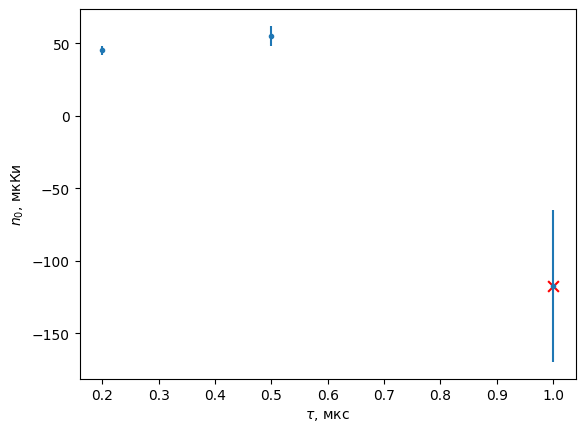

In [13]:
tau = list(tab['tau'])[0:3]
n0 = list(tab['n0'])[0:3]
dn0 = list(np.abs(tab['dn0']))[0:3]

mipt.plot(tau, n0, yerr=dn0, exclude=(2,), func=None)
plt.xlabel("$\\tau$, мкс")
plt.ylabel("$n_0$, мкКи")
plt.savefig("gen/n0_tau.png")

n0 = tab['n0'][0:2]
dn0 = tab['dn0'][0:2]
print('n0 = {} +- {}, {}%'.format(n0.mean(), dn0.mean() / math.sqrt(2), 0))